In [1]:
# https://www.kaggle.com/code/metric/santa-2023-metric
"""Evaluation metric for Santa 2023."""

import pandas as pd
from ast import literal_eval
from dataclasses import dataclass
from sympy.combinatorics import Permutation
from typing import Dict, List


class ParticipantVisibleError(Exception):
    pass


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        series_id_column_name: str,
        moves_column_name: str,
        puzzle_info_path: str,
) -> float:
    """Santa 2023 evaluation metric.

    Parameters
    ----------
    solution : pd.DataFrame

    submission : pd.DataFrame

    series_id_column_name : str

    moves_column_name : str

    Returns
    -------
    total_num_moves : int
    """
    if list(submission.columns) != [series_id_column_name, moves_column_name]:
        raise ParticipantVisibleError(
            f"Submission must have columns {series_id_column_name} and {moves_column_name}."
        )

    puzzle_info = pd.read_csv(puzzle_info_path, index_col='puzzle_type')
    total_num_moves = 0
    for sol, sub in zip(solution.itertuples(), submission.itertuples()):
        puzzle_id = getattr(sol, series_id_column_name)
        assert puzzle_id == getattr(sub, series_id_column_name)
        allowed_moves = literal_eval(puzzle_info.loc[sol.puzzle_type, 'allowed_moves'])
        allowed_moves = {k: Permutation(v) for k, v in allowed_moves.items()}
        puzzle = Puzzle(
            puzzle_id=puzzle_id,
            allowed_moves=allowed_moves,
            solution_state=sol.solution_state.split(';'),
            initial_state=sol.initial_state.split(';'),
            num_wildcards=sol.num_wildcards,
        )

        # Score submission row
        total_num_moves += score_puzzle(puzzle_id, puzzle, getattr(sub, moves_column_name))

    return total_num_moves


@dataclass
class Puzzle:
    """A permutation puzzle."""

    puzzle_id: str
    allowed_moves: Dict[str, List[int]]
    solution_state: List[str]
    initial_state: List[str]
    num_wildcards: int


def score_puzzle(puzzle_id, puzzle, sub_solution):
    """Score the solution to a permutation puzzle."""
    # Apply submitted sequence of moves to the initial state, from left to right
    moves = sub_solution.split('.')
    state = puzzle.initial_state
    for m in moves:
        power = 1
        if m[0] == "-":
            m = m[1:]
            power = -1
        try:
            p = puzzle.allowed_moves[m]
        except KeyError:
            raise ParticipantVisibleError(f"{m} is not an allowed move for {puzzle_id}.")
        state = (p ** power)(state)

    # Check that submitted moves solve puzzle
    num_wrong_facelets = sum(not(s == t) for s, t in zip(puzzle.solution_state, state))
    if num_wrong_facelets > puzzle.num_wildcards:
        raise ParticipantVisibleError(f"Submitted moves do not solve {puzzle_id}.")

    # The score for this instance is the total number of moves needed to solve the puzzle
    return len(moves)

- スコアは長さの和

In [3]:
import pandas as pd
from sympy.combinatorics import Permutation
from multiprocess import Pool, cpu_count

p = './santa-2023/'
path = pd.read_csv(p+'puzzles.csv')
info = pd.read_csv(p+'puzzle_info.csv')
sub = pd.read_csv(p+'sample_submission.csv')

In [4]:
path

,id,puzzle_type,solution_state,initial_state,num_wildcards
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0
...,...,...,...,...,...
393,393,globe_33/3,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,D;D;L;A;P;E;R;U;U;C;S;R;J;B;E;G;O;J;F;Q;R;E;D;...,0
394,394,globe_33/3,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,V;L;N;G;B;V;R;E;H;A;K;S;I;N;G;E;V;C;L;G;S;M;P;...,0
395,395,globe_33/3,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N12;N219;N227;N198;N4;N208;N214;N245;N56;N55;N...,0
396,396,globe_8/25,A;A;A;A;A;D;D;D;D;D;G;G;G;G;G;J;J;J;J;J;M;M;M;...,V;P;F;L;P;X;O;A;J;b;V;Y;D;Y;C;X;J;F;U;G;d;L;b;...,0


In [5]:
info

,puzzle_type,allowed_moves
0,cube_2/2/2,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
1,cube_3/3/3,"{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ..."
2,cube_4/4/4,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
3,cube_5/5/5,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
4,cube_6/6/6,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
5,cube_7/7/7,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
6,cube_8/8/8,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
7,cube_9/9/9,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
8,cube_10/10/10,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
9,cube_19/19/19,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."


In [6]:
sub

,id,moves
0,0,r1.-f1
1,1,f1.d0.-r0.-f1.-d0.-f1.d0.-r0.f0.-f1.-r0.f1.-d1...
2,2,f1.d0.-d1.r0.-d1.-f0.f1.-r0.-f0.-r1.-f0.r0.-d0...
3,3,-f0.-r0.-f0.-d0.-f0.f1.r0.-d1.-r0.-r1.-r0.-f1....
4,4,d1.-f1.d1.r1.-f0.d1.-d0.-r1.d1.d1.-f1.d1.-d0.-...
...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...


In [7]:
info['allowed_moves_count'] = info['allowed_moves'].map(lambda x: {k: Permutation(v) for k, v in eval(x).items()})
paths = pd.merge(path, info, how='left', on='puzzle_type')
paths = pd.merge(paths, sub, how='left', on='id')
paths['solution_state'] = paths['solution_state'].map(lambda x: x.split(';'))
paths['initial_state'] = paths['initial_state'].map(lambda x: x.split(';'))
paths['moves'] = paths['moves'].map(lambda x: x.split('.'))
paths.head(1)

,id,puzzle_type,solution_state,initial_state,num_wildcards,allowed_moves,allowed_moves_count,moves
0,0,cube_2/2/2,"[A, A, A, A, B, B, B, B, C, C, C, C, D, D, D, ...","[D, E, D, A, E, B, A, B, C, A, C, A, D, C, D, ...",0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...","{'f0': (23)(2 19 21 8)(3 17 20 10)(4 6 7 5), '...","[r1, -f1]"


In [8]:
#Evaluation metric for Santa 2023 - https://www.kaggle.com/code/metric/santa-2023-metric
# modified - using combined paths & info dataframe

def getMoves(puzzle_id, moves, allowed_moves, state, solution_state, num_wildcards):
#     for m in moves:
#         power = 1
#         if m[0] == "-":
#             m = m[1:]
#             power = -1
#         p = allowed_moves[m]
#         state = (p ** power)(state)
#     num_wrong_facelets = sum(not(s == t) for s, t in zip(solution_state, state))
#     if num_wrong_facelets > num_wildcards:
#         print(f"Submitted moves do not solve {puzzle_id}.")
    return len(moves)

def score(sol):
    p = Pool(cpu_count()-1)
    ret = p.starmap(getMoves, sol[['id','moves','allowed_moves_count','initial_state','solution_state','num_wildcards']].values)
    p.close(); p.join()
    return sum(ret)

In [9]:
%%time
score(paths)

CPU times: total: 1.3 s
Wall time: 5.58 s


1220590

In [10]:
# Visualizing Changes
def pPositions(s):
    o = """
        Positions                              

             +--------+                               +--------+
             | .0.    .1. |                               | A    A |
             |   d1   |                               |   d1   |
             | .2.    .3. |                               | A    A |
    +--------+--------+--------+--------+    +--------+--------+--------+--------+
    | .16.    .17. | .4.    .5. | .8.    .9. | .12.    .13. |    | E    E | B    B | C    C | D    D |
    |   r1   |   f0   |   r0   |   f1   |    |   r1   |   f0   |   r0   |   f1   |
    | .18.    .19. | .6.    .7. | .10.    .11. | .14.    .15. |    | E    E | B    B | C    C | D    D |
    +--------+--------+--------+--------+    +--------+--------+--------+--------+
             | .20.    .21. |                               | F    F |
             |   d0   |                               |   d0   |
             | .22.    .23. |                               | F    F |
             +--------+                               +--------+
    """
    for i in range(len(s)):
        o = o.replace('.'+str(i)+'.', s[i])
    return o

def getMoves(args):
    puzzle_id, moves, allowed_moves, state, solution_state, num_wildcards = args
    print(f"allowed_moves: {allowed_moves}")
    for m in moves:
        print(f"move: {m}")
        power = 1
        if m[0] == "-":
            m = m[1:]
            power = -1
        p = allowed_moves[m]
        print(f"perm: {p}")
        state = (p ** power)(state)
        print(f"state: {state}")
        print(pPositions(state))
    
#     num_wrong_facelets = sum(not(s == t) for s, t in zip(solution_state, state))
#     if num_wrong_facelets > num_wildcards:
#         print(f"Submitted moves do not solve {puzzle_id}.")
    return len(moves)

getMoves(paths[['id','moves','allowed_moves_count','initial_state','solution_state','num_wildcards']].values[0])

allowed_moves: {'f0': Permutation(23)(2, 19, 21, 8)(3, 17, 20, 10)(4, 6, 7, 5), 'f1': Permutation(0, 18, 23, 9)(1, 16, 22, 11)(12, 13, 15, 14), 'r0': Permutation(1, 5, 21, 14)(3, 7, 23, 12)(8, 10, 11, 9), 'r1': Permutation(23)(0, 4, 20, 15)(2, 6, 22, 13)(16, 17, 19, 18), 'd0': Permutation(6, 18, 14, 10)(7, 19, 15, 11)(20, 22, 23, 21), 'd1': Permutation(23)(0, 1, 3, 2)(4, 16, 12, 8)(5, 17, 13, 9)}
move: r1
perm: (23)(0 4 20 15)(2 6 22 13)(16 17 19 18)
state: ['E', 'E', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'A', 'C', 'A', 'D', 'D', 'D', 'D', 'F', 'E', 'F', 'E', 'F', 'F', 'C', 'C']

        Positions                              

             +--------+                               +--------+
             | E    E |                               | A    A |
             |   d1   |                               |   d1   |
             | A    A |                               | A    A |
    +--------+--------+--------+--------+    +--------+--------+--------+--------+
    | F    E | B    B | 

2

In [11]:
# paths['moves'] = paths['moves'].map(lambda x: '.'.join(x))
# paths[['id','moves']].to_csv('submission.csv', index=False)

# 可視化

In [12]:
info.loc[0]

puzzle_type                                                   cube_2/2/2
allowed_moves          {'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...
allowed_moves_count    {'f0': (23)(2 19 21 8)(3 17 20 10)(4 6 7 5), '...
Name: 0, dtype: object

In [13]:
allowed_moves=eval(info.at[0,"allowed_moves"])
allowed_moves

{'f0': [0,
  1,
  19,
  17,
  6,
  4,
  7,
  5,
  2,
  9,
  3,
  11,
  12,
  13,
  14,
  15,
  16,
  20,
  18,
  21,
  10,
  8,
  22,
  23],
 'f1': [18,
  16,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  0,
  10,
  1,
  13,
  15,
  12,
  14,
  22,
  17,
  23,
  19,
  20,
  21,
  11,
  9],
 'r0': [0,
  5,
  2,
  7,
  4,
  21,
  6,
  23,
  10,
  8,
  11,
  9,
  3,
  13,
  1,
  15,
  16,
  17,
  18,
  19,
  20,
  14,
  22,
  12],
 'r1': [4,
  1,
  6,
  3,
  20,
  5,
  22,
  7,
  8,
  9,
  10,
  11,
  12,
  2,
  14,
  0,
  17,
  19,
  16,
  18,
  15,
  21,
  13,
  23],
 'd0': [0,
  1,
  2,
  3,
  4,
  5,
  18,
  19,
  8,
  9,
  6,
  7,
  12,
  13,
  10,
  11,
  16,
  17,
  14,
  15,
  22,
  20,
  23,
  21],
 'd1': [1,
  3,
  0,
  2,
  16,
  17,
  6,
  7,
  4,
  5,
  10,
  11,
  8,
  9,
  14,
  15,
  12,
  13,
  18,
  19,
  20,
  21,
  22,
  23]}

In [14]:
for k,v in allowed_moves.items():
    print(k, len(v))

f0 24
f1 24
r0 24
r1 24
d0 24
d1 24


In [15]:
print(allowed_moves)

{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11, 12, 13, 14, 15, 16, 20, 18, 21, 10, 8, 22, 23], 'f1': [18, 16, 2, 3, 4, 5, 6, 7, 8, 0, 10, 1, 13, 15, 12, 14, 22, 17, 23, 19, 20, 21, 11, 9], 'r0': [0, 5, 2, 7, 4, 21, 6, 23, 10, 8, 11, 9, 3, 13, 1, 15, 16, 17, 18, 19, 20, 14, 22, 12], 'r1': [4, 1, 6, 3, 20, 5, 22, 7, 8, 9, 10, 11, 12, 2, 14, 0, 17, 19, 16, 18, 15, 21, 13, 23], 'd0': [0, 1, 2, 3, 4, 5, 18, 19, 8, 9, 6, 7, 12, 13, 10, 11, 16, 17, 14, 15, 22, 20, 23, 21], 'd1': [1, 3, 0, 2, 16, 17, 6, 7, 4, 5, 10, 11, 8, 9, 14, 15, 12, 13, 18, 19, 20, 21, 22, 23]}


In [16]:
allowed_moves.keys()

dict_keys(['f0', 'f1', 'r0', 'r1', 'd0', 'd1'])

In [17]:
path["num_wildcards"].value_counts()

0      318
2       34
4       14
6       10
8        7
10       4
16       3
18       2
42       1
34       1
38       1
54       1
176      1
12       1
Name: num_wildcards, dtype: int64

In [18]:
path.at[0,"solution_state"]

'A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F'

In [19]:
path.at[0,"initial_state"]

'D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C'

In [45]:
len(path.at[0,"initial_state"].split(";"))

24

In [44]:
len(path.at[0,"solution_state"].split(";"))

24

In [20]:
sub

,id,moves
0,0,r1.-f1
1,1,f1.d0.-r0.-f1.-d0.-f1.d0.-r0.f0.-f1.-r0.f1.-d1...
2,2,f1.d0.-d1.r0.-d1.-f0.f1.-r0.-f0.-r1.-f0.r0.-d0...
3,3,-f0.-r0.-f0.-d0.-f0.f1.r0.-d1.-r0.-r1.-r0.-f1....
4,4,d1.-f1.d1.r1.-f0.d1.-d0.-r1.d1.d1.-f1.d1.-d0.-...
...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...


- `allowed_moves`: 許される動き。逆動作もOK。各移動は[配列形式](https://docs.sympy.org/latest/modules/combinatorics/permutations.html)で与えられた順列。
- `*_state`: 色の配置
- `num_wildcards`: 間違えていい数
- `moves`: 動作を`.`で繋ぐ。逆動作は`-`をつける

# permutation理解

In [21]:
p = Permutation([0, 2, 1])
p

Permutation(1, 2)

In [22]:
[i^p for i in range(p.size)]

[0, 2, 1]

In [25]:
# mapping 2 to p[2]
2^p

1

In [26]:
# mapping 2 to p[2]
p(2)

1

In [27]:
# ループされる順序だけが表示される
# 要素数1は表示されない
Permutation([1, 3, 2, 0])

Permutation(0, 1, 3)

In [31]:
Permutation(0,1,3)

Permutation(0, 1, 3)

In [32]:
Permutation(1, 2)(3, 5)

Permutation(1, 2)(3, 5)

In [35]:
Permutation(1, 2)(1, 3)(2, 3)

Permutation(1, 3)

In [37]:
Permutation(1, 2)(1, 3)(2, 3).list()

[0, 3, 2, 1]

In [36]:
Permutation([0, 3, 2, 1])

Permutation(1, 3)

In [99]:
(Permutation([2, 0, 1])**-1).list()

[1, 2, 0]

In [100]:
(Permutation([0, 3, 2, 1])**-1).list()

[0, 3, 2, 1]

In [106]:
(Permutation([2, 0,3, 1])**-1).list()

[1, 3, 0, 2]

In [107]:
# org=[2, 0, 1]
org=[2, 0,3, 1]
# org=[0, 3, 2, 1]
inv=[0]*len(org)
for i, o in enumerate(org):
    inv[o]=i
inv

[1, 3, 0, 2]

# AtCoder形式へ変換

In [2]:
import pandas as pd
import numpy as np

In [3]:
p = './santa-2023/'
puzzles = pd.read_csv(p+'puzzles.csv')
puzzle_info = pd.read_csv(p+'puzzle_info.csv')
sample_submission = pd.read_csv(p+'sample_submission.csv')

In [323]:
df=puzzles.merge(puzzle_info, on="puzzle_type")
df

,id,puzzle_type,solution_state,initial_state,num_wildcards,allowed_moves
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
...,...,...,...,...,...,...
393,393,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,D;D;L;A;P;E;R;U;U;C;S;R;J;B;E;G;O;J;F;Q;R;E;D;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."
394,394,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,V;L;N;G;B;V;R;E;H;A;K;S;I;N;G;E;V;C;L;G;S;M;P;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."
395,395,globe_3/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N12;N219;N227;N198;N4;N208;N214;N245;N56;N55;N...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."
396,396,globe_8/25,A;A;A;A;A;D;D;D;D;D;G;G;G;G;G;J;J;J;J;J;M;M;M;...,V;P;F;L;P;X;O;A;J;b;V;Y;D;Y;C;X;J;F;U;G;d;L;b;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."


In [324]:
df["initial_state"]=df["initial_state"].str.split(";")

In [325]:
df["solution_state"]=df["solution_state"].str.split(";")

In [326]:
df["state_length"]=df["solution_state"].map(len)

In [327]:
df["allowed_moves"]=df["allowed_moves"].map(eval)

In [328]:
df["allowed_action_num"]=df["allowed_moves"].map(len)

In [329]:
df["perm_length"]=df["allowed_moves"].map(lambda x: len(list(x.values())[0]))

In [330]:
assert (df["state_length"]==df["perm_length"]).all()

In [331]:
from pathlib import Path
output_dir = Path(f"./data")
output_dir.mkdir(parents=True, exist_ok=True)
for i, row in df.iterrows():
    with open(output_dir / f"{row['id']}.txt", "w") as f:
        f.write(f'{row["puzzle_type"]}\n')
        f.write(f'{row["state_length"]}\n')
        f.write(f'{" ".join(row["initial_state"])}\n')
        f.write(f'{" ".join(row["solution_state"])}\n')
        f.write(f'{row["allowed_action_num"]}\n')
        for k,v in row["allowed_moves"].items():
            f.write(f"{k} {' '.join(map(str,v))}\n")
        f.write(f'{row["num_wildcards"]}\n')

# sample_submittionを分割

In [154]:
for i, row in submit.iterrows():
# for i, row in sample_submission.iterrows():
    filename=f"output/{i}.txt"
    with open(filename, "w") as f:
        f.write(row["moves"])

# デコード

In [3]:
import os
import pandas as pd
p = './santa-2023/'
sample_submission = pd.read_csv(p+'sample_submission.csv')

# https://www.kaggle.com/code/dinhttrandrise/bidirectional-brute-force-w-wildcards/notebook
# sample_submission = pd.read_csv('Bidirectional_Brute_Force_w_Wildcards.csv')

# https://www.kaggle.com/code/wrrosa/santa-2023-kociemba-s-two-phase-algo-1-116-550/output
# sample_submission = pd.read_csv('Kociemba_two_phase_algo.csv')

# https://www.kaggle.com/code/yunsuxiaozi/k-step-optimal-solution-santa/output?select=submission.csv
# sample_submission = pd.read_csv('K_step_optimal_solution.csv')

# https://www.kaggle.com/code/paulorzp/magic-cube-utilities/output
# sample_submission = pd.read_csv('Magic_Cube_Utilities.csv')
# →変化なし

# https://www.kaggle.com/code/seanbearden/kociemba-w-greedy-all-3x3x3-ensemble/output
# sample_submission = pd.read_csv('Kociemba_w_Greedy.csv')

# sample_submission = pd.read_csv('solver_submit.csv')
# sample_submission = pd.read_csv('submission.csv')

# sample_submission = pd.read_csv("Solve_All_NxNxN_Cubes_w_Traditional_Solution_State.csv")


In [4]:
case_num=398

In [102]:
submit=sample_submission.copy()
for i in range(case_num):
    filename=f"output/{i}.txt"
    with open(filename) as f:
        ans=f.readline()
        if len(ans.split("."))<=len(submit.at[i, "moves"].split(".")):
            submit.at[i, "moves"]=ans

In [105]:
submit.to_csv("submission.csv", index=False)

In [103]:
score=submit["moves"].str.split(".").map(len).sum()
score

816270

In [104]:
816270

816270

In [91]:
p = './santa-2023/'
puzzles = pd.read_csv(p+'puzzles.csv')
puzzles=puzzles.merge(submit,on="id", how="left")

In [92]:
puzzles["length"]=puzzles["moves"].str.split(".").map(len)

<AxesSubplot: xlabel='id'>

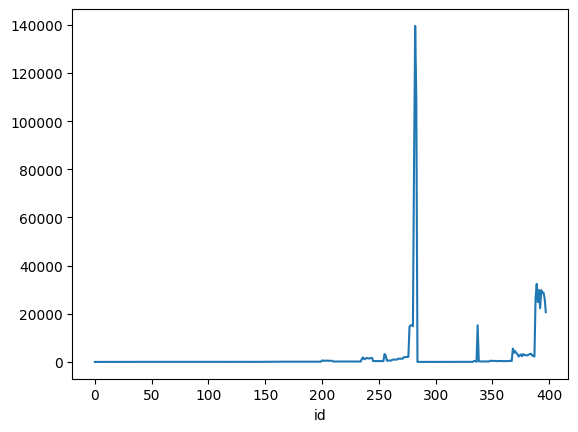

In [93]:
puzzles.set_index("id")["length"].plot()#.plot(kind="bar")

In [94]:
puzzles.sort_values("length").tail(10)

,id,puzzle_type,solution_state,initial_state,num_wildcards,moves,length
396,396,globe_8/25,A;A;A;A;A;D;D;D;D;D;G;G;G;G;G;J;J;J;J;J;M;M;M;...,V;P;F;L;P;X;O;A;J;b;V;Y;D;Y;C;X;J;F;U;G;d;L;b;...,0,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...,26362
388,388,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,G;Q;G;D;E;T;E;N;U;H;H;U;O;F;T;B;S;M;A;N;D;V;V;...,6,-f14.f23.-r1.f10.-f22.-f43.f4.f38.f22.f52.-f14...,26590
394,394,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,V;L;N;G;B;V;R;E;H;A;K;S;I;N;G;E;V;C;L;G;S;M;P;...,0,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...,28659
395,395,globe_3/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N12;N219;N227;N198;N4;N208;N214;N245;N56;N55;N...,0,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....,28758
393,393,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,D;D;L;A;P;E;R;U;U;C;S;R;J;B;E;G;O;J;F;Q;R;E;D;...,0,-f19.-f21.-f39.-f20.-f2.-f5.-f7.-r3.-f55.-f12....,29802
391,391,globe_3/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N237;N257;N199;N215;N54;N261;N50;N6;N57;N32;N2...,0,-f40.-f19.-f9.-f20.-f16.-f5.-f45.-f52.-f4.-f30...,29851
389,389,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,H;A;P;K;G;N;U;G;D;V;E;L;D;O;E;Q;D;A;A;H;L;J;A;...,0,f51.f11.-f1.-f42.f47.f10.-f49.-r3.-f51.f11.-f1...,32408
281,281,cube_33/33/33,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,B;F;C;B;E;F;A;F;F;C;B;A;F;A;D;C;C;B;E;E;C;D;B;...,0,f0.f1.f2.f3.f4.f5.f6.f7.f8.f9.f10.f11.f12.f13....,82665
283,283,cube_33/33/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N1056;N4357;N3264;N3270;N924;N2183;N1095;N6526...,0,f11.-d15.-r13.d0.-f0.f11.-r12.r29.-d4.-r28.-r2...,108592
282,282,cube_33/33/33,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;...,F;B;A;F;A;C;B;B;C;B;B;A;E;F;A;E;E;E;B;E;B;F;E;...,0,f7.-d1.r3.r25.-r2.r12.-f1.-r4.f25.r28.d7.f3.d8...,139545


In [23]:
puzzles.groupby("puzzle_type")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
puzzle_type,,,,,,,,
cube_10/10/10,5.0,2034.200000,57.798789,1958.0,2021.00,2027.0,2046.00,2119.0
cube_19/19/19,4.0,14967.750000,290.610134,14639.0,14765.75,15002.5,15204.50,15227.0
cube_2/2/2,30.0,10.500000,1.907336,2.0,10.00,11.0,11.75,13.0
cube_3/3/3,120.0,31.075000,2.701268,20.0,30.00,31.0,33.00,36.0
cube_33/33/33,3.0,110267.333333,28476.984678,82665.0,95628.50,108592.0,124068.50,139545.0
cube_4/4/4,60.0,161.966667,158.107448,76.0,90.00,96.0,101.00,605.0
cube_5/5/5,35.0,549.771429,617.332358,148.0,169.50,175.0,1166.00,1884.0
cube_6/6/6,12.0,786.166667,1044.973147,319.0,338.00,344.0,354.25,3289.0
cube_7/7/7,5.0,562.400000,34.558646,506.0,553.00,578.0,586.00,589.0


In [24]:
puzzles["t"]=puzzles["puzzle_type"].str[:4]
puzzles.groupby("t")["length"].agg(["sum", "mean", "min", "max"])

,sum,mean,min,max
t,,,,
cube,457622,1611.345070,2,139545
glob,342705,5711.750000,166,32408
wrea,17482,323.740741,2,15988


In [25]:
puzzles.drop_duplicates(subset=["puzzle_type"])

,id,puzzle_type,solution_state,initial_state,num_wildcards,moves,length,t
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0,r1.-f1,2,cube
30,30,cube_3/3/3,A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;...,A;A;E;C;F;F;C;C;C;D;B;D;D;B;A;B;F;F;A;E;B;D;E;...,0,d0.d2.f2.-r2.f2.-d2.-d2.r0.d2.-r2.f0.-d2.-r2.-...,30,cube
150,150,cube_4/4/4,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;...,B;A;A;A;C;B;C;F;A;C;A;D;F;D;E;A;D;C;A;B;F;A;B;...,0,-d0.-r3.-r3.-f3.-f2.-f3.-f2.-r0.-r1.d0.-f0.-f1...,94,cube
210,210,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,A;D;D;B;E;B;B;E;D;F;C;B;F;F;F;F;E;D;A;D;F;A;A;...,0,f4.f3.r0.r1.r0.r1.d0.d1.d0.d1.-r0.-f4.-f3.-r0....,171,cube
245,245,cube_6/6/6,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,E;D;E;F;B;A;A;B;C;D;C;A;C;C;E;F;C;F;C;A;F;E;E;...,2,d0.d1.d2.d0.d1.d2.r0.-f5.-f5.-d5.-d4.f5.f4.f3....,342,cube
257,257,cube_7/7/7,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,C;A;A;B;E;F;C;F;E;D;D;C;A;C;C;F;C;D;C;D;C;E;B;...,42,f0.f1.f2.-r0.-d6.-r6.-r5.-r4.f6.f5.f4.r0.r1.r2...,589,cube
262,262,cube_8/8/8,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,D;C;E;C;F;C;F;F;C;C;E;B;D;E;A;D;D;B;D;C;C;A;A;...,0,-d0.-d1.-d2.-d3.r0.r1.r2.r0.r1.r2.-f7.-f6.-f5....,964,cube
267,267,cube_9/9/9,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,E;C;B;D;B;F;C;D;C;A;A;B;A;D;C;F;E;C;A;A;F;D;C;...,38,d0.-f8.-f7.-f6.-f5.-f8.-f7.-f6.-f5.-r8.-r7.-r6...,1340,cube
272,272,cube_10/10/10,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,F;C;A;F;A;E;E;E;E;B;F;C;C;E;E;E;E;C;B;E;D;A;C;...,0,r0.r1.r2.r3.-d9.-d8.-d7.-d6.-d9.-d8.-d7.-d6.-r...,1958,cube
277,277,cube_19/19/19,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,B;D;C;D;D;A;D;D;E;F;A;C;F;C;C;B;E;D;A;E;B;E;B;...,176,f0.-d18.-d17.-d16.-d15.-d14.-d13.-d12.-d11.-d1...,14639,cube


In [26]:
puzzles.drop_duplicates(subset=["puzzle_type", "solution_state"])

,id,puzzle_type,solution_state,initial_state,num_wildcards,moves,length,t
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0,r1.-f1,2,cube
20,20,cube_2/2/2,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N22;N0;N1;N2;N12;N17;N20;N5;N4;N13;N3;N21;N16;...,0,-r1.d0.-d1.-f1.-r0.-f1.d0.r1.d0.-r1.d0.d0,12,cube
25,25,cube_2/2/2,A;B;A;B;B;C;B;C;C;D;C;D;D;E;D;E;E;F;E;F;F;A;F;A,C;F;B;D;F;A;E;D;D;E;D;C;E;A;B;F;C;A;F;E;A;B;B;C,0,r0.r0.d0.-f0.d0.-f0.-d1.-r0.f0.-r0.f0.f0.r0,13,cube
30,30,cube_3/3/3,A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;...,A;A;E;C;F;F;C;C;C;D;B;D;D;B;A;B;F;F;A;E;B;D;E;...,0,d0.d2.f2.-r2.f2.-d2.-d2.r0.d2.-r2.f0.-d2.-r2.-...,30,cube
130,130,cube_3/3/3,A;B;A;B;A;B;A;B;A;B;C;B;C;B;C;B;C;B;C;D;C;D;C;...,C;B;D;B;B;C;F;E;A;B;D;D;B;C;A;A;E;B;E;F;A;F;A;...,0,d2.f2.-d2.f2.d2.f0.d2.r2.d0.-f2.-f2.r0.d2.-r2....,26,cube
140,140,cube_3/3/3,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N33;N7;N42;N19;N4;N52;N9;N48;N0;N38;N43;N29;N2...,6,-d2.-d2.-f0.-d2.f2.-r2.-d2.-r2.f0.f0.-f2.d0.-f...,31,cube
150,150,cube_4/4/4,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;...,B;A;A;A;C;B;C;F;A;C;A;D;F;D;E;A;D;C;A;B;F;A;B;...,0,-d0.-r3.-r3.-f3.-f2.-f3.-f2.-r0.-r1.d0.-f0.-f1...,94,cube
200,200,cube_4/4/4,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,C;A;A;B;E;E;C;E;D;B;B;C;E;D;C;A;F;A;C;F;F;D;D;...,0,r0.d1.-d2.-f2.r3.-f2.-f3.d2.-d1.-r0.-f1.-f3.d2...,605,cube
205,205,cube_4/4/4,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N3;N33;N20;N0;N50;N85;N53;N72;N7;N22;N41;N66;N...,0,r3.-r0.f0.-f1.-f2.r3.-f2.-r0.r3.r2.-r1.-r0.-d3...,544,cube
210,210,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,A;D;D;B;E;B;B;E;D;F;C;B;F;F;F;F;E;D;A;D;F;A;A;...,0,f4.f3.r0.r1.r0.r1.d0.d1.d0.d1.-r0.-f4.-f3.-r0....,171,cube


# wreath
https://www.kaggle.com/code/asiknow/visualize-wreath-21-21-21

In [33]:
import pandas as pd
from sympy.combinatorics import Permutation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from ipywidgets import interactive
import ipywidgets as widgets


# File paths
puzzle_info_path = 'santa-2023/puzzle_info.csv'
puzzles_path = 'santa-2023/puzzles.csv'
sample_submission_path = 'santa-2023/sample_submission.csv'

# Loading the data
info = pd.read_csv(puzzle_info_path)
puzzles = pd.read_csv(puzzles_path)
ss = pd.read_csv(sample_submission_path)

In [34]:
#### figure out the circles
x_center1 = 80
y_center1 = 50
radius1 = 40
angle1 = 2*np.pi * 6 / 21
l_chord = 2 * radius1 * np.sin(angle1/2)
x_chord = x_center1 + radius1 * np.cos(angle1/2)
angle2 = 2*np.pi * 7 / 21
radius2 = l_chord / 2 / np.sin(angle2/2)
x_center2 = x_chord + radius2 * np.cos(angle2/2)
y_center2 = y_center1

x_nodes = []
y_nodes = []
for i in range(21):
    angle_node0 = -angle1/2 + i * 2*np.pi / 21
    x_node0 = x_center1 + radius1 * np.cos(angle_node0)
    y_node0 = y_center1 + radius1 * np.sin(angle_node0)
    x_nodes.append(x_node0)
    y_nodes.append(y_node0)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20]:
    angle_node0 = np.pi + angle2/2 + i * 2*np.pi / 21
    x_node0 = x_center2 + radius2 * np.cos(angle_node0)
    y_node0 = y_center2 + radius2 * np.sin(angle_node0)
    x_nodes.append(x_node0)
    y_nodes.append(y_node0)

In [35]:
def plot_wreath212121(puzzle_idx, solution=False):
    node_types = puzzles.loc[puzzle_idx]['initial_state'].split(";")
    if solution:
        node_types = puzzles.loc[puzzle_idx]['solution_state'].split(";")
    color_map = {'A':'blue', 'B':'red', 'C':'yellow'}

    circle1 = plt.Circle((x_center1, y_center1), radius1, color='black', fill = False)
    circle2 = plt.Circle((x_center2, y_center2), radius2, color='black', fill = False)
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    ax.set_aspect('equal', adjustable='box')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    for i, (x, y) in enumerate(zip(x_nodes,y_nodes)):
        circle_node = plt.Circle((x, y), 5, color=color_map[node_types[i]], fill = True)
        ax.add_patch(circle_node)


    plt.xlim([0, 200])
    plt.ylim([0, 100])


    plt.show()


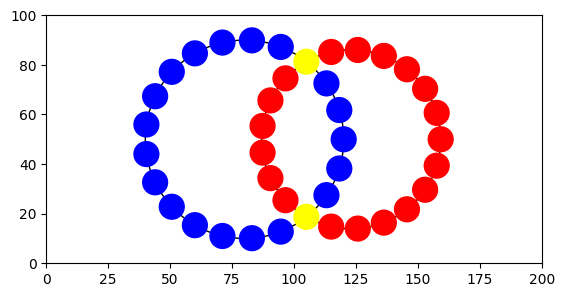

In [36]:
# Let's see the solution state
plot_wreath212121(329,True)

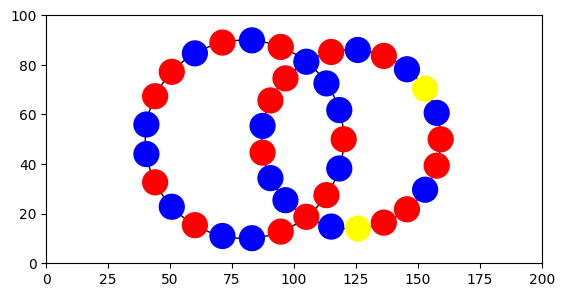

In [37]:
# puzzle 329
plot_wreath212121(329)

In [46]:
puzzle_idx = 329
example = puzzles.loc[puzzle_idx]
moves = info.loc[info['puzzle_type'] == example['puzzle_type']]['allowed_moves'].values[0]
moves = eval(moves)
moves_ = moves.copy()
for m, d in moves_.items():
    moves[f'-{m}'] = list(np.argsort(d))
# solution_steps = ss.loc[puzzle_idx]['moves']
# solution_steps = "l.r.l.l.r.l.l.l.l.l.l.r.l.l.r.r.l.r.r.r.r.r.r.r.r.r.r.r.r.r.r.l"
# solution_steps ="-l.-r.-r.l.r.l.-r.-r.-r.l.l.-r.-r.-r.l.l.l.-r.-r.l.l.l.-r.-r.-r.-r.l.l.r"
# solution_steps ="l.r.r.r.r.r.l.l.r.r.r.l.l.l.l.l.l.l.l.r.r.r.r.r.r.r.r.r.l.l.l.l"
solution_steps ="l.r.r.r.r.r.l.l.r.r.r.l.l.l.l.l.l.l.l.r.r.r.r.r.r.r.r.r.l.l.l.l.-r.-r.-r.-r.-l.-l.-l.-r.-r.-r.-r.l.l.l.-r.-r.-r.-l.-l.-r.l.r.-l.r.r.r.r.r.r.-l"
initialstate = puzzles.loc[puzzle_idx]['initial_state'].split(";")
now = np.array(initialstate)
states = [now]
for move in solution_steps.split('.'):
    now = now[moves[move]]
    states.append(now)
steps = list(range(len(states)))
def plot_wreath2121_329_interact(istate):
    node_types = states[istate]
    color_map = {'A':'blue', 'B':'red', 'C':'yellow'}

    circle1 = plt.Circle((x_center1, y_center1), radius1, color='black', fill = False)
    circle2 = plt.Circle((x_center2, y_center2), radius2, color='black', fill = False)
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    ax.set_aspect('equal', adjustable='box')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    for i, (x, y) in enumerate(zip(x_nodes,y_nodes)):
        circle_node = plt.Circle((x, y), 5, color=color_map[node_types[i]], fill = True)
        ax.add_patch(circle_node)


    plt.xlim([0, 200])
    plt.ylim([0, 100])


    plt.show()

#interactive_plot = interactive(plot_wreath2121_329_interact, istate=widgets.IntSlider(value=0,
#                                               min=0,
#                                               max=len(states)-1,
#                                               step=1))
interactive_plot = interactive(plot_wreath2121_329_interact, istate=steps)
interactive_plot

interactive(children=(Dropdown(description='istate', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

# ソルバー
- http://kociemba.org/cube.htm

In [28]:
# import optimal.solver as sv
# import twophase.solver as tsv

In [29]:
# import pandas as pd
# import numpy as np
# from sympy.combinatorics import Permutation

# p = 'santa-2023/'
# path = pd.read_csv(p + 'puzzles.csv')
# info = pd.read_csv(p + 'puzzle_info.csv')
# sub = pd.read_csv(p+'sample_submission.csv')

# info['allowed_moves_count'] = info['allowed_moves'].map(lambda x: {k: Permutation(v) for k, v in eval(x).items()})
# paths = pd.merge(path, info, how='left', on='puzzle_type')
# paths = pd.merge(paths, sub, how='left', on='id')

In [207]:
# # https://www.kaggle.com/code/wrrosa/santa-2023-kociemba-s-two-phase-algo-1-116-550
# U = ['U', 'F', 'R', 'B', 'L', 'D']
# def state2ubl(state):
#     dct = {}
#     for u in range(len(U)):
#         dct[state.split(';')[4+u*9]] = U[u]
#     s = ''.join([dct[f] for f in state.split(';')])
#     return s[:9] + s[18:27] + s[9:18] + s[45:] + s[36:45] + s[27:36]

In [208]:
# moves = eval(info.loc[info['puzzle_type'] == 'cube_3/3/3']['allowed_moves'].values[0])
# for move in list(moves):
#     moves['-'+move] = np.argsort(moves[move]).tolist()

# M = {}
# M["U"] = '-d2'
# M["R"] = "r0"
# M["B"] = "-f2"
# M["F"] = "f0"
# M["L"] = "-r2"
# M["D"] = "d0"
# for m in list(M):
#     M[m+"2"] = M[m] + '.' + M[m]
#     if "-" in M[m]:
#         M[m+"'"] = M[m].replace("-","")
#     else:
#         M[m+"'"] = "-"+M[m]

In [30]:
# for i in paths.loc[paths['puzzle_type'] == 'cube_3/3/3'].iterrows():
#     try:
#         id = i[1]['id']
#         cur_state = i[1]['initial_state']
        
#         sol = sv.solve(state2ubl(cur_state))

#         new_state = cur_state
#         mmoves = '.'.join([M[m] for m in sol.split(' ')])

#         for move in mmoves.split('.'):
#             new_state = ';'.join(list(np.asarray(new_state.split(';'))[np.array(moves[move])]))
#         I = ['r0.r1.r2','d0.d1.d2','f0.f1.f2']
#         for init_moves in [''] + I + [i1 + '.' + i2 for i1 in I for i2 in I]+ [i1 + '.' + i2+ '.' + i3 for i1 in I for i2 in I for i3 in I]+ [i1 + '.' + i2+ '.' + i3 + '.' + i4 for i1 in I for i2 in I for i3 in I for i4 in I]:
#             temp_state = new_state
#             if len(init_moves) > 0:
#                 for move in init_moves.split('.'):
#                     temp_state = ';'.join(list(np.asarray(temp_state.split(';'))[np.array(moves[move])]))

#             if temp_state == i[1]['solution_state']:
#                 print(f'solved id: {id}')
#                 if len(init_moves) > 0:
#                     mmoves += '.' + init_moves
#                 if len(paths.iloc[id,7].split('.')) > len(mmoves.split('.')):
#                     print(f"improved: new length {len(mmoves.split('.'))} vs current length {len(paths.iloc[id,7].split('.'))}")
#                     paths.iloc[id,7] = mmoves
#                 break
#     except:
#         pass

In [31]:
# class ParticipantVisibleError(Exception):
#     pass

# def score(sol) -> float:
#     total_num_moves = 0
#     for i in range(len(sol)):
#         puzzle_id=sol['id'][i]
#         moves = sol.moves[i].split('.')
#         allowed_moves=sol.allowed_moves_count[i]
#         state = sol.initial_state[i].split(';')
#         solution_state=sol.solution_state[i].split(';')
#         num_wildcards=sol.num_wildcards[i]
#         for m in moves:
#             power = 1
#             if m[0] == "-":
#                 m = m[1:]
#                 power = -1
#             try:
#                 p = allowed_moves[m]
#             except KeyError:
#                 raise ParticipantVisibleError(f"{m} is not an allowed move for {puzzle_id}.")
#             state = (p ** power)(state)
#         num_wrong_facelets = sum(not(s == t) for s, t in zip(solution_state, state))
#         if num_wrong_facelets > num_wildcards:
#             print(puzzle_id, num_wrong_facelets, puzzle.num_wildcards)
#             raise ParticipantVisibleError(f"Submitted moves do not solve {puzzle_id}.")
#         total_num_moves += len(moves)
#     return total_num_moves

In [ ]:
# %%time
# score(paths)

In [32]:
# paths[['id','moves']].to_csv('solver_result.csv', index=False)

In [168]:
cubestring="UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB"
tsv.solve(cubestring)

'(0f)'

In [171]:
solver_input.at[30,"solution_state"]

'UUUUUUUUUFFFFFFFFFRRRRRRRRRBBBBBBBBBLLLLLLLLLDDDDDDDDD'

In [169]:
cubestring="UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB"
tsv.solve(cubestring)

'(0f)'

In [139]:
p = './santa-2023/'
puzzles = pd.read_csv(p+'puzzles.csv')
puzzle_info = pd.read_csv(p+'puzzle_info.csv')

In [140]:
puzzles.loc[puzzles["puzzle_type"]=="cube_3/3/3"].drop_duplicates(subset=["solution_state"])

,id,puzzle_type,solution_state,initial_state,num_wildcards
30,30,cube_3/3/3,A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;...,A;A;E;C;F;F;C;C;C;D;B;D;D;B;A;B;F;F;A;E;B;D;E;...,0
130,130,cube_3/3/3,A;B;A;B;A;B;A;B;A;B;C;B;C;B;C;B;C;B;C;D;C;D;C;...,C;B;D;B;B;C;F;E;A;B;D;D;B;C;A;A;E;B;E;F;A;F;A;...,0
140,140,cube_3/3/3,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N33;N7;N42;N19;N4;N52;N9;N48;N0;N38;N43;N29;N2...,6


In [146]:
from collections import Counter
Counter(puzzles.at[30,"initial_state"])

Counter({'A': 9, ';': 53, 'E': 9, 'C': 9, 'F': 9, 'D': 9, 'B': 9})

In [141]:
# puzzles.at[30, "solution_state"].replace(";","")
puzzles.at[30, "solution_state"]

'A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;C;C;C;C;D;D;D;D;D;D;D;D;D;E;E;E;E;E;E;E;E;E;F;F;F;F;F;F;F;F;F'

In [124]:
# AAAAAAAAABBBBBBBBBCCCCCCCCCDDDDDDDDDEEEEEEEEEFFFFFFFFF
tb = [['A','y','u'],
      ['B','g','f'],
      ['C','o','r'],
      ['D','b','b'],
      ['E','r','l'],
      ['F','w','d']]


In [157]:
mapping={
    "A":"U",
    "B":"F",
    "C":"R",
    "D":"B",
    "E":"L",
    "F":"D"
}

In [158]:
solver_input=puzzles[puzzles["solution_state"]=="A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;C;C;C;C;D;D;D;D;D;D;D;D;D;E;E;E;E;E;E;E;E;E;F;F;F;F;F;F;F;F;F"   ]
solver_input["solution_state"]=solver_input["solution_state"].str.replace(";","").map(
    lambda x: "".join([mapping[c] for c in x])
)
solver_input["initial_state"]=solver_input["initial_state"].str.replace(";","").str.replace(";","").map(
    lambda x: "".join([mapping[c] for c in x])
)

C:\cygwin64\tmp\ipykernel_6012\3019945060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solver_input["solution_state"]=solver_input["solution_state"].str.replace(";","").map(
C:\cygwin64\tmp\ipykernel_6012\3019945060.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solver_input["initial_state"]=solver_input["initial_state"].str.replace(";","").str.replace(";","").map(


In [163]:
Counter(solver_input.at[30,"initial_state"]), Counter(solver_input.at[30,"solution_state"])

(Counter({'U': 9, 'L': 9, 'R': 9, 'D': 9, 'B': 9, 'F': 9}),
 Counter({'U': 9, 'F': 9, 'R': 9, 'B': 9, 'L': 9, 'D': 9}))

In [167]:
tsv.solve(solver_input.at[30,"initial_state"])

'Error: Some edges are undefined.'

In [164]:
answers=[]
for i, row in solver_input.iterrows():
    ans=tsv.solve(row["initial_state"])
    print(ans)
    answers.append(ans)

Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Som